In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#imports
import pathlib as pl
import PIL
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import math
import pandas as pd
from typing import List, Optional, Tuple, Dict

import time

# Title

## 1. EDA

### Initial Data Assessment

In [3]:
data = pl.Path('/kaggle/input/histopathologic-cancer-detection')
test = data/'test'
train = data/'train'
train_labels = data/'train_labels.csv'

In [4]:
labels_df = pd.read_csv(train_labels)
test_list = list(test.glob('*.tif'))
test_df = pd.DataFrame({'paths': test_list})
assert len(labels_df) == 220025
assert len(test_df) == 57458

In [5]:
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
def gen_train_paths(row):
    file = row.id + '.tif'
    path = train/file
    #check that all of the training images exist (slow)
    #assert path.exists()
    return path
labels_df['paths'] = labels_df.progress_apply(gen_train_paths, axis = 1)

100%|██████████| 220025/220025 [00:02<00:00, 79556.80it/s]


In [7]:
n = labels_df.label.sum()
N = len(labels_df)
s = f'There are {n} positive training images and {N-n} negative training images.\nThis is a slight imbalance in favor of the negative class but unlikely to severely impact training.'
print(s)

There are 89117 positive training images and 130908 negative training images.
This is a slight imbalance in favor of the negative class but unlikely to severely impact training.


### Structure Verification

In [8]:
def validate_image_dimensions(data_df, expected_shape=(96, 96, 3), sample_size=None):
    """
    Validate that all images in the dataset have the expected dimensions.
    
    Parameters:
    - data_df: DataFrame with 'paths' column containing image file paths
    - expected_shape: Tuple of expected (height, width, channels)
    - sample_size: Optional integer to check only a sample of images
    
    Returns:
    - Dictionary containing validation results and statistics
    """
    
    
    # Determine which images to check
    if sample_size and sample_size < len(data_df):
        check_df = data_df.sample(n=sample_size, random_state=42)
        print(f"Checking sample of {sample_size} images from {len(data_df)} total")
    else:
        check_df = data_df
        print(f"Checking all {len(check_df)} images")
    
    # Initialize tracking variables
    correct_shape_count = 0
    incorrect_shapes = []
    corrupted_files = []
    shape_distribution = {}
    
    start_time = time.time()
    
    # Check each image
    for idx, row in tqdm(check_df.iterrows(), total=len(check_df), desc="Validating images"):
        try:
            img = Image.open(row['paths'])
            img_array = np.array(img)
            shape = img_array.shape
            
            # Track shape distribution
            shape_str = str(shape)
            shape_distribution[shape_str] = shape_distribution.get(shape_str, 0) + 1
            
            # Check if shape matches expected
            if shape == expected_shape:
                correct_shape_count += 1
            else:
                incorrect_shapes.append({
                    'id': row['id'],
                    'path': row['paths'],
                    'actual_shape': shape,
                    'expected_shape': expected_shape
                })
                
        except Exception as e:
            corrupted_files.append({
                'id': row['id'],
                'path': row['paths'],
                'error': str(e)
            })
    
    elapsed_time = time.time() - start_time
    
    # Compile results
    results = {
        'total_checked': len(check_df),
        'correct_shape_count': correct_shape_count,
        'incorrect_shape_count': len(incorrect_shapes),
        'corrupted_count': len(corrupted_files),
        'shape_distribution': shape_distribution,
        'incorrect_shapes': incorrect_shapes,
        'corrupted_files': corrupted_files,
        'validation_time': f"{elapsed_time:.2f} seconds",
        'all_correct': len(incorrect_shapes) == 0 and len(corrupted_files) == 0
    }
    
    # Print summary
    print(f"\nValidation Summary:")
    print(f"Total images checked: {results['total_checked']}")
    print(f"Correct shape ({expected_shape}): {results['correct_shape_count']} "
          f"({100 * results['correct_shape_count'] / results['total_checked']:.1f}%)")
    print(f"Incorrect shape: {results['incorrect_shape_count']}")
    print(f"Corrupted/unreadable: {results['corrupted_count']}")
    print(f"Time taken: {results['validation_time']}")
    
    if results['incorrect_shape_count'] > 0:
        print(f"\nShape distribution found:")
        for shape, count in shape_distribution.items():
            print(f"  {shape}: {count} images")
    
    return results

In [9]:
validate_image_dimensions(labels_df, expected_shape=(96, 96, 3), sample_size=3000)

Checking sample of 3000 images from 220025 total


Validating images: 100%|██████████| 3000/3000 [00:42<00:00, 71.24it/s]


Validation Summary:
Total images checked: 3000
Correct shape ((96, 96, 3)): 3000 (100.0%)
Incorrect shape: 0
Corrupted/unreadable: 0
Time taken: 42.11 seconds


{'total_checked': 3000,
 'correct_shape_count': 3000,
 'incorrect_shape_count': 0,
 'corrupted_count': 0,
 'shape_distribution': {'(96, 96, 3)': 3000},
 'incorrect_shapes': [],
 'corrupted_files': [],
 'validation_time': '42.11 seconds',
 'all_correct': True}

### Visual Inspection

In [10]:
def visualize_histopathology_samples(
    data_df: pd.DataFrame,
    n: int,
    figsize_per_image: Tuple[float, float] = (3, 3.5),
    max_cols: int = 5,
    title: str = "Histopathologic Image Samples",
    save_path: Optional[Path] = None,
    dpi: int = 100,
    random_state: Optional[int] = None
) -> plt.Figure:
    """
    Visualize a random sample of histopathology images in a grid layout with class labels.
    
    This function creates a professional visualization suitable for exploratory data
    analysis of the Kaggle histopathologic cancer detection dataset. Each image is
    displayed with its classification label and filename for easy reference.
    
    Parameters
    ----------
    data_df : pd.DataFrame
        DataFrame containing columns 'id', 'label', and 'paths'.
        - 'id': Image identifier (string)
        - 'label': Binary label (0 or 1)
        - 'paths': Path to image file (string or Path object)
    n : int
        Number of images to randomly sample and display.
        If n exceeds the DataFrame size, all images are displayed.
    figsize_per_image : Tuple[float, float], default=(3, 3.5)
        Size (width, height) in inches for each image subplot.
        Includes space for title and labels.
    max_cols : int, default=5
        Maximum number of columns in the grid layout.
        Rows are calculated automatically based on the number of images.
    title : str, default="Histopathologic Image Samples"
        Main title for the entire figure.
    save_path : Path, optional
        If provided, saves the figure to this path.
    dpi : int, default=100
        Dots per inch for saved figure (if save_path is provided).
    random_state : int, optional
        Random seed for reproducible sampling.
    
    Returns
    -------
    matplotlib.figure.Figure
        The created figure object for further customization if needed.
    
    Raises
    ------
    ValueError
        If required columns are missing from the DataFrame.
        If an image cannot be loaded or is not in the expected format.
    
    Examples
    --------
    >>> # Load and prepare data
    >>> labels_df = pd.read_csv('train_labels.csv')
    >>> train_dir = Path('train')
    >>> labels_df['paths'] = labels_df['id'].apply(lambda x: train_dir / f'{x}.tif')
    >>> 
    >>> # Visualize 20 random samples
    >>> fig = visualize_histopathology_samples(
    ...     labels_df, 
    ...     n=20,
    ...     max_cols=4,
    ...     save_path=Path('eda_sample_images.png')
    ... )
    """
    
    # Validate required columns
    required_columns = {'id', 'label', 'paths'}
    if not required_columns.issubset(data_df.columns):
        missing = required_columns - set(data_df.columns)
        raise ValueError(f"Missing required columns: {missing}")
    
    # Sample n rows from the dataframe
    if len(data_df) <= n:
        sample_df = data_df.copy()
    else:
        sample_df = data_df.sample(n=n, random_state=random_state)
    
    # Convert paths column to Path objects if needed
    sample_df['paths'] = sample_df['paths'].apply(lambda x: Path(x) if not isinstance(x, Path) else x)
    
    # Calculate grid dimensions
    n_images = len(sample_df)
    n_cols = min(n_images, max_cols)
    n_rows = math.ceil(n_images / n_cols)
    
    # Create figure with calculated size
    fig_width = n_cols * figsize_per_image[0]
    fig_height = n_rows * figsize_per_image[1]
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.98)
    
    # Create grid specification for better spacing control
    gs = fig.add_gridspec(n_rows, n_cols, hspace=0.3, wspace=0.2, 
                         top=0.94, bottom=0.02, left=0.02, right=0.98)
    
    # Process and display each image
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        grid_row = idx // n_cols
        grid_col = idx % n_cols
        ax = fig.add_subplot(gs[grid_row, grid_col])
        
        try:
            # Load and display image
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Verify expected image format
            if img_array.shape != (96, 96, 3):
                print(f"Warning: Image {row['id']} has unexpected shape {img_array.shape}")
            
            ax.imshow(img_array)
            
            # Get label information from DataFrame row
            image_id = row['id']
            label = row['label']
            
            # Format label text with appropriate color
            if label == 1:
                label_text = "Positive (Cancer)"
                label_color = 'darkred'
            elif label == 0:
                label_text = "Negative (Normal)"
                label_color = 'darkgreen'
            else:
                label_text = "Unknown Label"
                label_color = 'gray'
            
            # Set title with class label
            ax.set_title(f"{label_text}\n{image_id}", 
                        fontsize=10, pad=5, color=label_color)
            
            # Remove axis ticks for cleaner appearance
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add subtle border
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)
                
        except Exception as e:
            # Handle loading errors gracefully
            ax.text(0.5, 0.5, f"Error loading\n{row['id']}\n{str(e)}", 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=9, color='red', wrap=True)
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Remove any empty subplots
    for idx in range(n_images, n_rows * n_cols):
        grid_row = idx // n_cols
        grid_col = idx % n_cols
        ax = fig.add_subplot(gs[grid_row, grid_col])
        ax.set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Figure saved to: {save_path}")
    
    # Close the figure to prevent duplicate display
    plt.close(fig)
    
    return fig


def create_class_comparison_visualization(
    data_df: pd.DataFrame,
    n_per_class: int = 10,
    figsize_per_image: Tuple[float, float] = (3, 3),
    save_path: Optional[Path] = None,
    random_state: Optional[int] = None
) -> plt.Figure:
    """
    Create a side-by-side comparison visualization of positive and negative samples.
    
    This specialized function arranges images to facilitate visual comparison between
    cancer-positive and cancer-negative tissue samples, which is particularly useful
    for understanding class differences during exploratory data analysis.
    
    Parameters
    ----------
    data_df : pd.DataFrame
        DataFrame containing columns 'id', 'label', and 'paths'.
    n_per_class : int, default=10
        Number of samples to display for each class.
    figsize_per_image : Tuple[float, float], default=(2.5, 3)
        Size for each image subplot.
    save_path : Path, optional
        Path to save the comparison figure.
    random_state : int, optional
        Random seed for reproducible sampling.
    
    Returns
    -------
    matplotlib.figure.Figure
        The created comparison figure.
    
    Examples
    --------
    >>> # Create comparison visualization
    >>> fig = create_class_comparison_visualization(
    ...     data_df,
    ...     n_per_class=8,
    ...     save_path=Path('class_comparison.png')
    ... )
    """
    
    # Separate positive and negative samples
    positive_df = data_df[data_df['label'] == 1]
    negative_df = data_df[data_df['label'] == 0]
    
    # Sample from each class
    if len(positive_df) > n_per_class:
        positive_sample = positive_df.sample(n=n_per_class, random_state=random_state)
    else:
        positive_sample = positive_df
    
    if len(negative_df) > n_per_class:
        negative_sample = negative_df.sample(n=n_per_class, random_state=random_state)
    else:
        negative_sample = negative_df
    
    # Combine samples alternating between classes for easy comparison
    combined_df = pd.concat([positive_sample, negative_sample])
    
    # Reset index to ensure proper ordering
    positive_sample = positive_sample.reset_index(drop=True)
    negative_sample = negative_sample.reset_index(drop=True)
    
    # Create interleaved dataframe for side-by-side comparison
    interleaved_rows = []
    for i in range(max(len(positive_sample), len(negative_sample))):
        if i < len(positive_sample):
            interleaved_rows.append(positive_sample.iloc[i])
        if i < len(negative_sample):
            interleaved_rows.append(negative_sample.iloc[i])
    
    comparison_df = pd.DataFrame(interleaved_rows)
    
    # Create visualization with clear class separation
    n_total = len(comparison_df)
    fig = visualize_histopathology_samples(
        comparison_df,
        n=n_total,  # Display all samples since we already sampled
        figsize_per_image=figsize_per_image,
        max_cols=2,  # Two columns for side-by-side comparison
        title=f"Positive vs Negative Sample Comparison (n={min(len(positive_sample), len(negative_sample))} per class)",
        save_path=save_path
    )
    
    return fig
#This code block was generated by Claude Opus 4

/tmp/ipykernel_35/1499395991.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


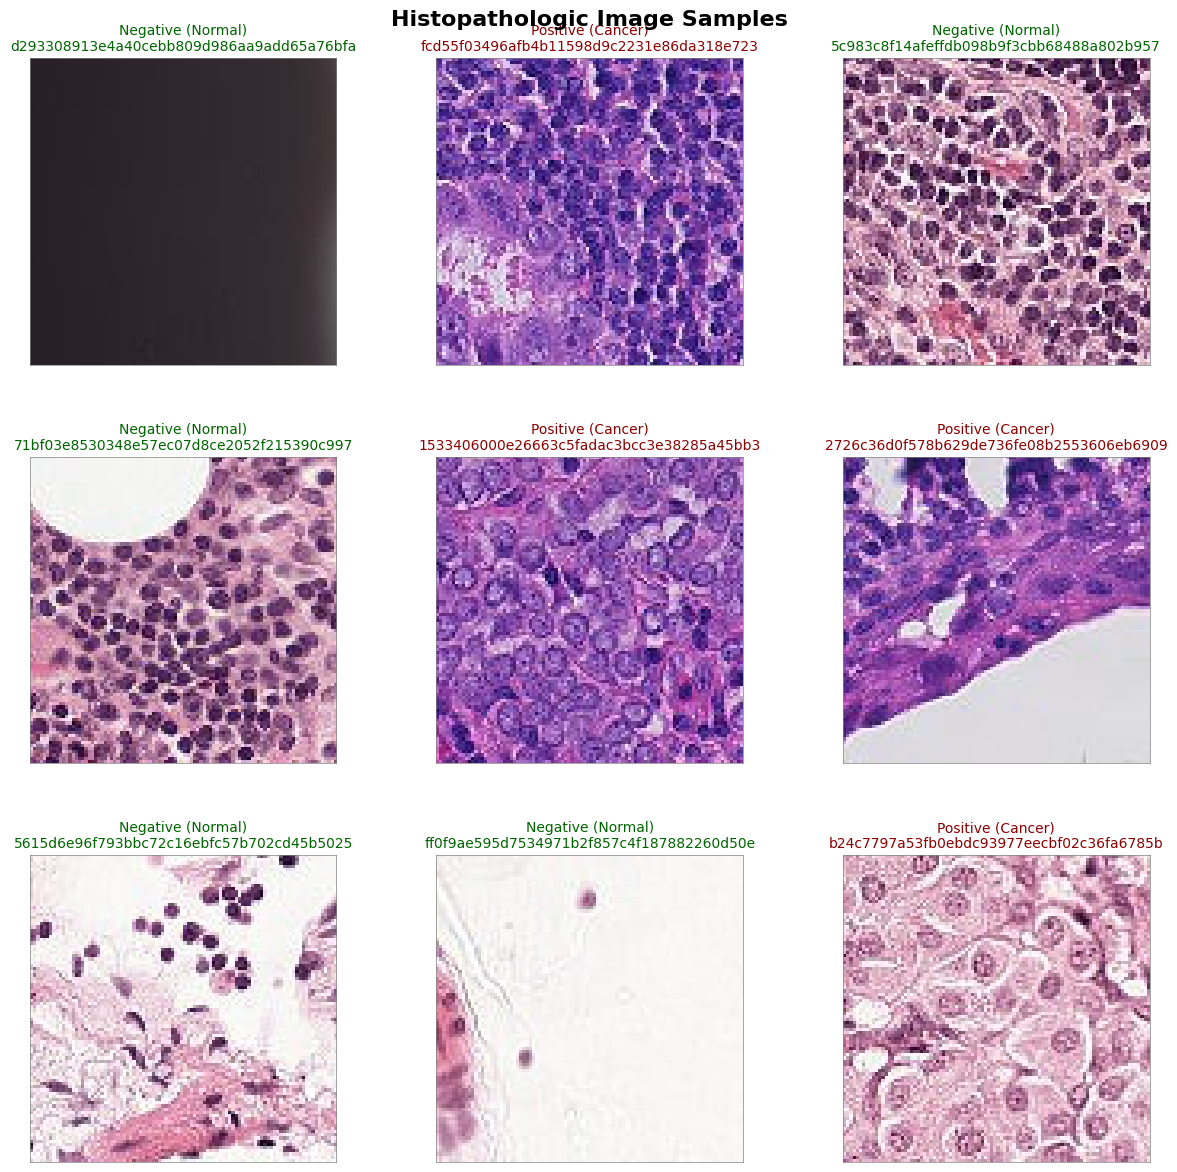

In [11]:
visualize_histopathology_samples(
    data_df = labels_df,
    n = 9,
    figsize_per_image = (4,4),
    max_cols = 3,
    title = "Histopathologic Image Samples",
    save_path = None,
    dpi = 100,
    random_state = 42
)

In [12]:
def detect_monochromatic_images(data_df, variance_threshold=5.0, n_samples=None):
    """
    Detect images that are essentially monochromatic (single color).
    
    Parameters:
    - data_df: DataFrame containing 'id', 'label', and 'paths' columns
    - variance_threshold: Maximum standard deviation to consider an image monochromatic
    - n_samples: Optional number of images to check (None for all)
    
    Returns:
    - DataFrame containing information about monochromatic images
    """
    import numpy as np
    from PIL import Image
    from tqdm import tqdm
    
    # Determine sample size
    if n_samples:
        check_df = data_df.sample(n=min(n_samples, len(data_df)), random_state=42)
    else:
        check_df = data_df
    
    monochromatic_images = []
    
    for _, row in tqdm(check_df.iterrows(), total=len(check_df), 
                      desc="Scanning for monochromatic images"):
        try:
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Calculate statistics for each channel
            channel_stats = {}
            for c, channel_name in enumerate(['R', 'G', 'B']):
                channel_data = img_array[:, :, c]
                channel_stats[channel_name] = {
                    'mean': np.mean(channel_data),
                    'std': np.std(channel_data),
                    'min': np.min(channel_data),
                    'max': np.max(channel_data)
                }
            
            # Calculate overall image variance
            overall_std = np.std(img_array)
            
            # Determine if image is monochromatic
            is_monochromatic = overall_std < variance_threshold
            
            # Classify the type of monochromatic image
            if is_monochromatic:
                mean_intensity = np.mean(img_array)
                if mean_intensity < 50:
                    mono_type = 'dark'
                elif mean_intensity > 200:
                    mono_type = 'white'
                else:
                    mono_type = 'gray'
                
                monochromatic_images.append({
                    'id': row['id'],
                    'label': row['label'],
                    'path': row['paths'],
                    'overall_std': overall_std,
                    'mean_intensity': mean_intensity,
                    'type': mono_type,
                    'r_std': channel_stats['R']['std'],
                    'g_std': channel_stats['G']['std'],
                    'b_std': channel_stats['B']['std']
                })
                
        except Exception as e:
            print(f"Error processing {row['id']}: {e}")
    
    # Create results DataFrame
    results_df = pd.DataFrame(monochromatic_images)
    
    # Print summary
    print(f"\nMonochromatic Image Detection Results:")
    print(f"Total images checked: {len(check_df)}")
    print(f"Monochromatic images found: {len(results_df)}")
    
    if len(results_df) > 0:
        print(f"\nBreakdown by type:")
        type_counts = results_df['type'].value_counts()
        for mono_type, count in type_counts.items():
            print(f"  {mono_type}: {count} images")
        
        print(f"\nLabel distribution of monochromatic images:")
        label_counts = results_df['label'].value_counts()
        for label, count in label_counts.items():
            print(f"  Class {label}: {count} images ({100*count/len(results_df):.1f}%)")
    
    return results_df

In [13]:
mono_df = detect_monochromatic_images(labels_df, variance_threshold=5.0, n_samples=10000)

Scanning for monochromatic images: 100%|██████████| 10000/10000 [01:39<00:00, 100.18it/s]


Monochromatic Image Detection Results:
Total images checked: 10000
Monochromatic images found: 33

Breakdown by type:
  white: 28 images
  dark: 5 images

Label distribution of monochromatic images:
  Class 0: 31 images (93.9%)
  Class 1: 2 images (6.1%)


In [14]:
def visualize_monochromatic_analysis(mono_df, data_df, n_examples=6, save_path=None):
    """
    Visualize monochromatic images and their distribution in the dataset.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from PIL import Image
    
    fig = plt.figure(figsize=(15, 10))
    
    # Plot 1: Examples of monochromatic images
    n_to_show = min(n_examples, len(mono_df))
    for i in range(n_to_show):
        ax = plt.subplot(3, n_examples, i + 1)
        img_info = mono_df.iloc[i]
        
        img = Image.open(img_info['path'])
        ax.imshow(np.array(img))
        ax.set_title(f"ID: {img_info['id']}\nLabel: {img_info['label']}\n"
                    f"Type: {img_info['type']}\nStd: {img_info['overall_std']:.2f}",
                    fontsize=8)
        ax.axis('off')
    
    # Plot 2: Distribution of monochromatic images by label
    ax2 = plt.subplot(3, 2, 3)
    if len(mono_df) > 0:
        label_counts = mono_df['label'].value_counts()
        colors = ['darkgreen', 'darkred']
        bars = ax2.bar(label_counts.index, label_counts.values, 
                       color=[colors[i] for i in label_counts.index])
        ax2.set_xlabel('Class Label')
        ax2.set_ylabel('Count')
        ax2.set_title('Monochromatic Images by Class')
        ax2.set_xticks([0, 1])
        ax2.set_xticklabels(['Negative', 'Positive'])
        
        # Add percentage labels
        total_by_class = data_df['label'].value_counts()
        for i, (label, count) in enumerate(label_counts.items()):
            percentage = 100 * count / total_by_class[label]
            ax2.text(i, count + 0.5, f'{percentage:.2f}%', ha='center')
    
    # Plot 3: Intensity distribution of monochromatic images
    ax3 = plt.subplot(3, 2, 4)
    if len(mono_df) > 0:
        ax3.hist(mono_df['mean_intensity'], bins=30, edgecolor='black', alpha=0.7)
        ax3.set_xlabel('Mean Pixel Intensity')
        ax3.set_ylabel('Count')
        ax3.set_title('Intensity Distribution of Monochromatic Images')
        ax3.axvline(x=50, color='red', linestyle='--', label='Dark threshold')
        ax3.axvline(x=200, color='blue', linestyle='--', label='White threshold')
        ax3.legend()
    
    # Plot 4: Proportion comparison
    ax4 = plt.subplot(3, 1, 3)
    total_counts = data_df['label'].value_counts().sort_index()
    if len(mono_df) > 0:
        mono_counts = mono_df['label'].value_counts().sort_index()
        
        x = np.arange(2)
        width = 0.35
        
        bars1 = ax4.bar(x - width/2, total_counts, width, label='Total Images', alpha=0.7)
        bars2 = ax4.bar(x + width/2, mono_counts, width, label='Monochromatic', alpha=0.7)
        
        ax4.set_xlabel('Class Label')
        ax4.set_ylabel('Count')
        ax4.set_title('Comparison of Total vs Monochromatic Images by Class')
        ax4.set_xticks(x)
        ax4.set_xticklabels(['Negative', 'Positive'])
        ax4.legend()
        ax4.set_yscale('log')  # Log scale to show both clearly
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.close()
    return fig

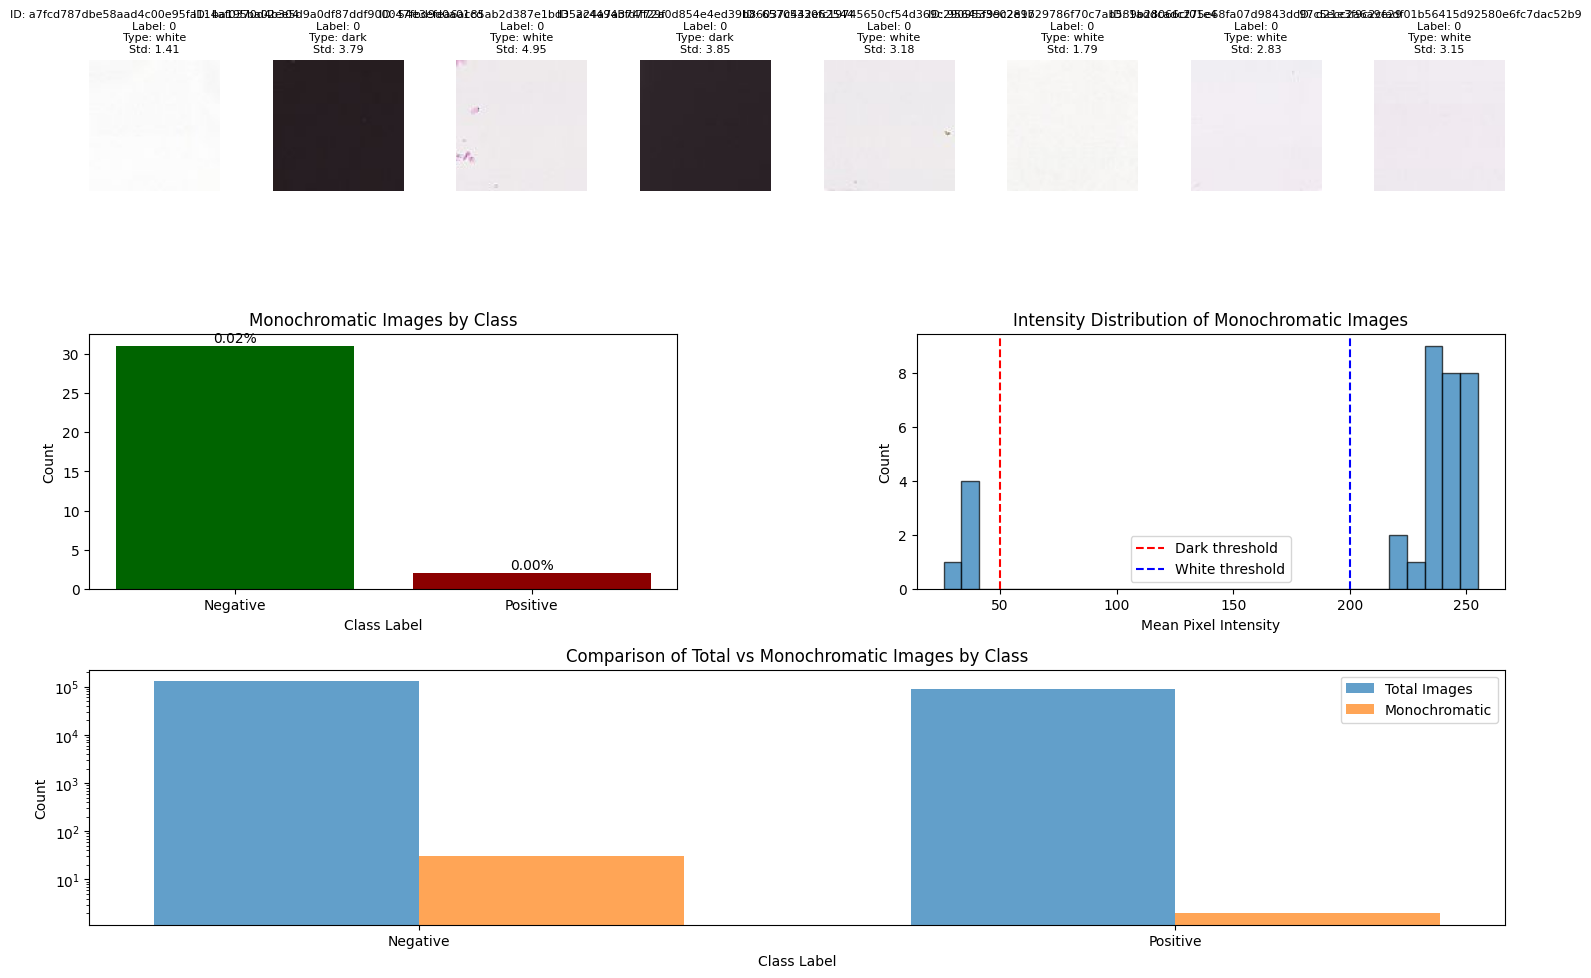

In [15]:
visualize_monochromatic_analysis(mono_df, labels_df, n_examples=8, save_path=None)

/tmp/ipykernel_35/1499395991.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


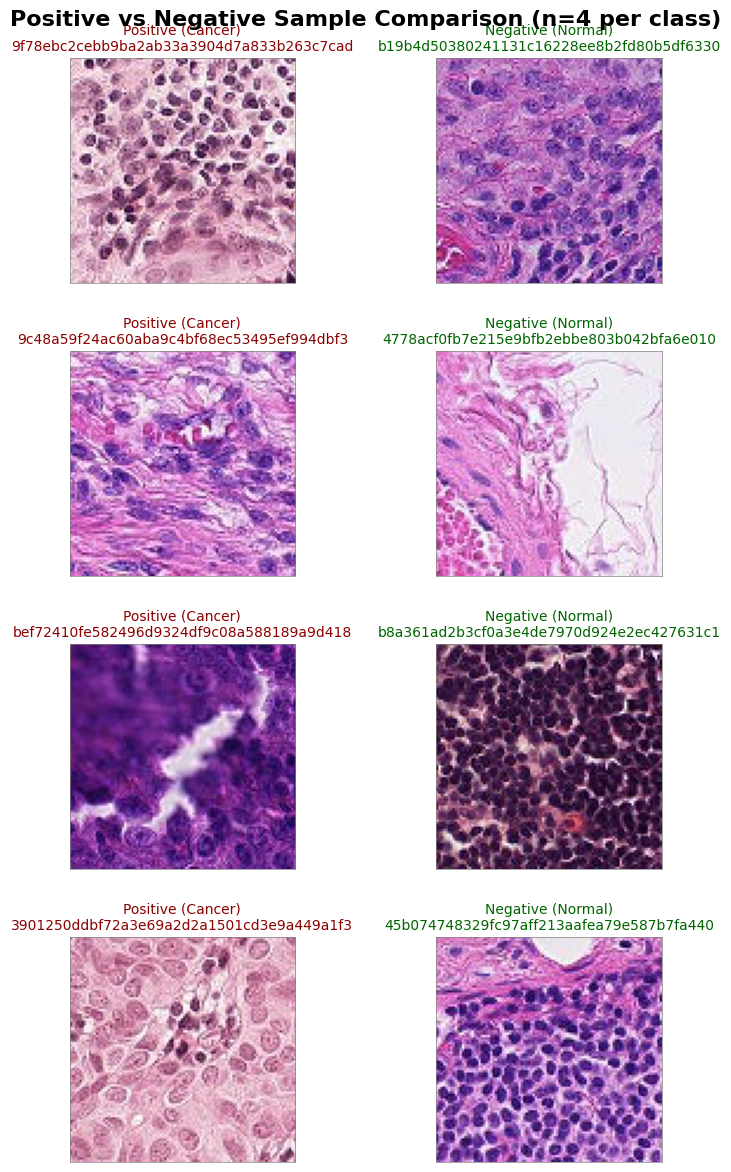

In [16]:
create_class_comparison_visualization(labels_df, n_per_class = 4, figsize_per_image = (3.5,3))

### Pixel Intensities

In [17]:
def analyze_pixel_distributions(data_df, n_samples=5000, random_state=42):
    """
    Analyze pixel intensity distributions across classes and color channels.
    
    Parameters:
    - data_df: DataFrame with 'paths' and 'label' columns
    - n_samples: Number of images to analyze (default 5000 for efficiency)
    - random_state: Random seed for reproducible sampling
    
    Returns:
    - Dictionary containing computed statistics and data for visualization
    """
    import numpy as np
    from PIL import Image
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore')
    
    # Sample data for efficiency
    sample_df = data_df.sample(n=min(n_samples, len(data_df)), random_state=random_state)
    
    # Initialize storage for pixel values by class and channel
    pixel_data = {
        0: {'R': [], 'G': [], 'B': [], 'gray': []},
        1: {'R': [], 'G': [], 'B': [], 'gray': []}
    }
    
    # Collect pixel intensities
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df), 
                      desc="Analyzing pixel intensities"):
        try:
            img = Image.open(row['paths'])
            img_array = np.array(img)
            
            # Extract each channel
            pixel_data[row['label']]['R'].extend(img_array[:,:,0].flatten())
            pixel_data[row['label']]['G'].extend(img_array[:,:,1].flatten())
            pixel_data[row['label']]['B'].extend(img_array[:,:,2].flatten())
            
            # Calculate grayscale for overall intensity
            gray = np.mean(img_array, axis=2)
            pixel_data[row['label']]['gray'].extend(gray.flatten())
            
        except Exception as e:
            print(f"Error processing {row['id']}: {e}")
    
    # Compute statistics
    statistics = {}
    for label in [0, 1]:
        statistics[label] = {}
        for channel in ['R', 'G', 'B', 'gray']:
            channel_data = np.array(pixel_data[label][channel])
            statistics[label][channel] = {
                'mean': np.mean(channel_data),
                'std': np.std(channel_data),
                'median': np.median(channel_data),
                'q1': np.percentile(channel_data, 25),
                'q3': np.percentile(channel_data, 75)
            }
    
    return pixel_data, statistics

In [18]:
data, stats = analyze_pixel_distributions(labels_df, n_samples=5000, random_state=42)

Analyzing pixel intensities: 100%|██████████| 5000/5000 [00:22<00:00, 217.53it/s]


In [19]:
def visualize_pixel_distributions(pixel_data, statistics, save_path=None):
    """
    Create comprehensive visualization of pixel intensity distributions.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set up the figure with subplots
    fig = plt.figure(figsize=(20, 10))
    
    # Define colors for consistency
    colors = {'R': '#E74C3C', 'G': '#27AE60', 'B': '#3498DB', 'gray': '#7F8C8D'}
    class_names = {0: 'Negative (Normal)', 1: 'Positive (Cancer)'}
    
    # Create 2x3 grid: top row for histograms, bottom for box plots
    for idx, (label, label_name) in enumerate(class_names.items()):
        # Histogram for RGB channels
        ax1 = plt.subplot(2, 3, idx*3 + 1)
        for channel in ['R', 'G', 'B']:
            # Sample for visualization efficiency
            sample_pixels = np.random.choice(pixel_data[label][channel], 
                                           size=min(100000, len(pixel_data[label][channel])), 
                                           replace=False)
            ax1.hist(sample_pixels, bins=50, alpha=0.6, density=True, 
                    label=f"{channel} (μ={statistics[label][channel]['mean']:.1f})",
                    color=colors[channel])
        
        ax1.set_title(f'{label_name} - RGB Channel Distributions', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Pixel Intensity')
        ax1.set_ylabel('Density')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Box plot comparison
        ax2 = plt.subplot(2, 3, idx*3 + 2)
        box_data = []
        box_labels = []
        for channel in ['R', 'G', 'B', 'gray']:
            # Sample for box plot
            sample_pixels = np.random.choice(pixel_data[label][channel], 
                                           size=min(5000, len(pixel_data[label][channel])), 
                                           replace=False)
            box_data.append(sample_pixels)
            box_labels.append(channel)
        
        bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False)
        for patch, channel in zip(bp['boxes'], ['R', 'G', 'B', 'gray']):
            patch.set_facecolor(colors[channel])
            patch.set_alpha(0.7)
        
        ax2.set_title(f'{label_name} - Intensity Distributions by Channel', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Pixel Intensity')
        ax2.grid(True, alpha=0.3, axis='y')
    
    # Create comparison plot between classes
    ax3 = plt.subplot(2, 3, 3)
    for channel in ['R', 'G', 'B']:
        for label in [0, 1]:
            sample_pixels = np.random.choice(pixel_data[label][channel], 
                                           size=min(50000, len(pixel_data[label][channel])), 
                                           replace=False)
            ax3.hist(sample_pixels, bins=50, alpha=0.4, density=True,
                    label=f"{class_names[label]} - {channel}",
                    color=colors[channel], linestyle='-' if label == 0 else '--')
    
    ax3.set_title('Class Comparison - All Channels', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Pixel Intensity')
    ax3.set_ylabel('Density')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Statistical comparison heatmap
    ax4 = plt.subplot(2, 3, 6)
    
    # Prepare data for heatmap
    diff_matrix = []
    labels = []
    for channel in ['R', 'G', 'B', 'gray']:
        diff_mean = statistics[1][channel]['mean'] - statistics[0][channel]['mean']
        diff_std = statistics[1][channel]['std'] - statistics[0][channel]['std']
        diff_matrix.append([diff_mean, diff_std])
        labels.append(channel)
    
    im = ax4.imshow(diff_matrix, cmap='RdBu_r', aspect='auto', vmin=-10, vmax=10)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(['Mean Diff', 'Std Diff'])
    ax4.set_yticks(range(len(labels)))
    ax4.set_yticklabels(labels)
    ax4.set_title('Statistical Differences (Positive - Negative)', fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('Intensity Difference')
    
    # Add values to heatmap
    for i in range(len(labels)):
        for j in range(2):
            text = ax4.text(j, i, f'{diff_matrix[i][j]:.1f}',
                           ha="center", va="center", color="black", fontsize=10)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {save_path}")
    
    plt.close()
    return fig

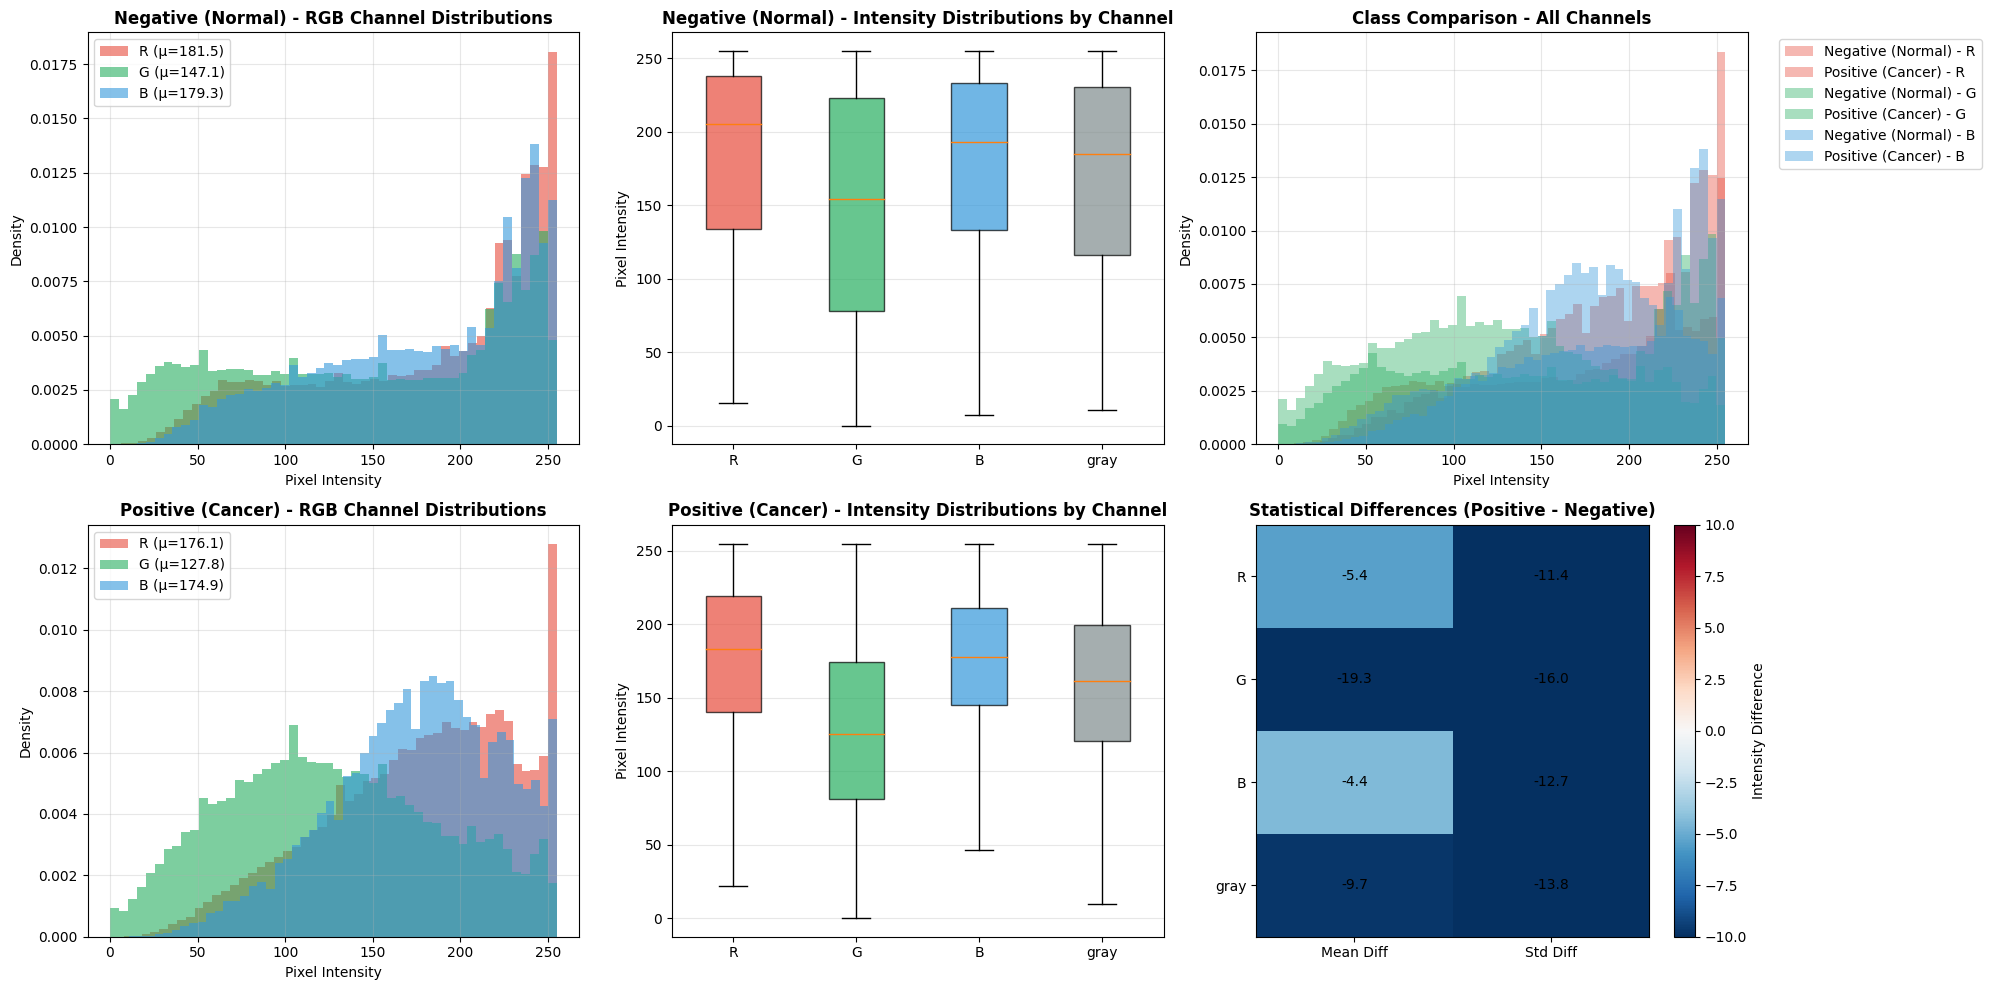

In [20]:
visualize_pixel_distributions(data, stats, save_path=None)

### Model Specification

In [31]:
#!pip install keras-tuner
#!pip install ipdb
import tensorflow as tf
from tensorflow import keras 
import keras_tuner
import ipdb
from keras import Sequential, Input, layers, optimizers, losses
def build_model(hp):
    m = keras.Sequential()
    m.add(Input(shape = (96,96,3)))
    
    crop = hp.Int("crop", min_value = 32, max_value = 96, sampling = 'linear', default = 32)
    m.add(layers.CenterCrop(crop,crop))
    #m.add(layers.Lambda(lambda x: tf.cast(x, tf.float32)))
    #m.add(layers.Rescaling(1/255))

    n_blocks = hp.Int('n_blocks', min_value = 1, max_value = 3, default = 1)
    init_filters = hp.Int('init_filters', min_value = 16, max_value = 64, sampling = 'log', default = 32)
    filter_scale = hp.Float('filter_scale', min_value = 1.25, max_value = 2, default = 1.5)
    n_filters = init_filters
    padding = hp.Choice('padding', ['valid', 'same'], default = 'same')
    conv_per = hp.Int('conv_per_block', min_value = 1, max_value = 3, default = 2)
    batch = hp.Boolean('batch')
    
    #ipdb.set_trace()    
    for i in range(n_blocks):
        for j in range(conv_per):
            m.add(layers.Conv2D(filters = n_filters, kernel_size = (3,3), padding = padding))
            n_filters = int(np.floor(n_filters*filter_scale))
            
            if batch:
                m.add(layers.BatchNormalization())

            m.add(layers.ReLU())
            
        m.add(layers.MaxPooling2D(pool_size = (2,2), strides = None, padding = 'valid'))


    dropout = hp.Float('dropout', min_value = .4, max_value = .8, default = .6)
    m.add(layers.Flatten())
    m.add(layers.Dropout(dropout))

    units = hp.Int('dense_units', min_value = 128, max_value = 256, sampling = 'log', default = 200)
    m.add(layers.Dense(units = units, activation = 'relu'))
    m.add(layers.Dropout(dropout))

    m.add(layers.Dense(1, activation = 'sigmoid'))

    smoothing = hp.Float('smoothing', min_value = 1e-8, max_value = 1e-1, sampling = 'log',default = 1e-4)
    loss = keras.losses.BinaryCrossentropy(
        from_logits=False,
        label_smoothing=smoothing,
        axis=-1,
        reduction="sum_over_batch_size",
        name="binary_crossentropy",
        dtype=None,
    )
    
    lr = hp.Float('learning_rate', min_value = 1e-5, max_value = 1e-3, sampling = 'log', default = 1e-5)
    opt = hp.Choice('optimizer', ['adam', 'rmsprop'], default = 'adam')
    
    rho = 1 - hp.Float('rho', min_value = 1e-2, max_value = 2e-1, sampling = 'log', default = .1)
    momentum = hp.Float('momentum', min_value = 1e-2, max_value = 5e-1, sampling = 'log', default = 1e-2)

    beta_1 = 1 - hp.Float('beta_1', min_value = 1e-2, max_value = 2e-1, sampling = 'log', default = 1e-1)
    beta_2 = 1 - hp.Float('beta_2', min_value = 1e-4, max_value = 1e-2, sampling = 'log', default = 1e-3)
    if opt == 'adam':
        
        optimizer = keras.optimizers.Adam(
            learning_rate=lr,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=1e-07,
            amsgrad=False,
            weight_decay=None,
            clipnorm=None,
            clipvalue=None,
            global_clipnorm=None,
            use_ema=False,
            ema_momentum=0.99,
            ema_overwrite_frequency=None,
            loss_scale_factor=None,
            gradient_accumulation_steps=None,
            name="adam"
        )
    else:
        
        optimizer = keras.optimizers.RMSprop(
            learning_rate=lr,
            rho=rho,
            momentum=momentum,
            epsilon=1e-07,
            centered=False,
            weight_decay=None,
            clipnorm=None,
            clipvalue=None,
            global_clipnorm=None,
            use_ema=False,
            ema_momentum=0.99,
            ema_overwrite_frequency=None,
            loss_scale_factor=None,
            gradient_accumulation_steps=None,
            name="rmsprop"
        )
    m.compile(
        optimizer=optimizer,
        loss=loss,
        loss_weights=None,
        metrics=['accuracy', 'AUC'],
        weighted_metrics=None,
        run_eagerly=False,
        steps_per_execution=1,
        jit_compile="auto",
        auto_scale_loss=True,
    )
        
    return m
default_model = build_model(keras_tuner.HyperParameters())

In [22]:
early = tf.keras.callbacks.EarlyStopping(monitor = 'val_AUC', 
                                         patience = 2,
                                        restore_best_weights=True,
                                        start_from_epoch=4)
bayes = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective='AUC',
    max_trials=16,
    num_initial_points=8,
    alpha=0.0001,
    beta=2.6,
    seed=42,
    hyperparameters=None,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    overwrite =True,
    max_consecutive_failed_trials=5
)
bayes.search_space_summary()

Search space summary
Default search space size: 16
crop (Int)
{'default': 32, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 1, 'sampling': 'linear'}
n_blocks (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
init_filters (Int)
{'default': 32, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': None, 'sampling': 'log'}
filter_scale (Float)
{'default': 1.5, 'conditions': [], 'min_value': 1.25, 'max_value': 2.0, 'step': None, 'sampling': 'linear'}
padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['valid', 'same'], 'ordered': False}
conv_per_block (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
batch (Boolean)
{'default': False, 'conditions': []}
dropout (Float)
{'default': 0.6, 'conditions': [], 'min_value': 0.4, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}
dense_units (Int)
{'default': 200, 'conditions': [], 'min_value': 128, 'max_va

### Train Model

#### Generate Datasets

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path

def create_generators(data_df, validation_size=0.2, batch_size=32, random_state=42):
    """
    Create training and validation generators from a single DataFrame.
    
    Parameters
    ----------
    data_df : pd.DataFrame
        DataFrame containing 'paths' and 'label' columns with all training data
        The 'paths' column can contain either strings or pathlib Path objects
        The 'label' column can contain either integers (0, 1) or strings
    validation_size : float, default=0.2
        Proportion of data to use for validation (0.0 to 1.0)
    batch_size : int, default=32
        Batch size for training and validation
    random_state : int, default=42
        Random seed for reproducible train/validation split
    
    Returns
    -------
    train_generator : DirectoryIterator
        Generator for training data with augmentation
    val_generator : DirectoryIterator
        Generator for validation data without augmentation
    train_df : pd.DataFrame
        DataFrame containing training samples (for reference)
    val_df : pd.DataFrame
        DataFrame containing validation samples (for reference)
    """
    
    # Create a copy to avoid modifying the original DataFrame
    data_df = data_df.copy()
    
    # Convert Path objects to strings if necessary
    if len(data_df) > 0 and isinstance(data_df['paths'].iloc[0], Path):
        print("Converting Path objects to strings...")
        data_df['paths'] = data_df['paths'].astype(str)
    
    # Convert integer labels to strings for binary classification
    if data_df['label'].dtype in ['int64', 'int32', 'int16', 'int8']:
        print("Converting integer labels to strings...")
        data_df['label'] = data_df['label'].astype(str)
    
    # Perform stratified train-validation split
    train_df, val_df = train_test_split(
        data_df,
        test_size=validation_size,
        stratify=data_df['label'],
        random_state=random_state
    )
    
    # Reset indices to avoid issues with flow_from_dataframe
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    
    # Print split information
    print(f"\nDataset split:")
    print(f"  Total samples: {len(data_df)}")
    print(f"  Training samples: {len(train_df)} ({100*(1-validation_size):.0f}%)")
    print(f"  Validation samples: {len(val_df)} ({100*validation_size:.0f}%)")
    print(f"\nClass distribution:")
    print(f"  Training: {dict(train_df['label'].value_counts().sort_index())}")
    print(f"  Validation: {dict(val_df['label'].value_counts().sort_index())}")
    
    # Define augmentation for training data
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,  # 90-degree rotations for histopathology
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        zoom_range=0.1,
        fill_mode='reflect'
    )
    
    # Validation data should only be rescaled
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create training generator
    print(f"\nCreating generators with batch_size={batch_size}...")
    print("Note: Skipping file validation for faster initialization...")
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='paths',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=42,
        validate_filenames=False  # Skip file existence validation
    )
    
    # Create validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='paths',
        y_col='label',
        target_size=(96, 96),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,  # Don't shuffle validation data
        validate_filenames=False  # Skip file existence validation
    )
    
    # Calculate steps per epoch for reference
    steps_per_epoch = len(train_df) // batch_size
    validation_steps = len(val_df) // batch_size
    
    print(f"\nGenerator information:")
    print(f"  Steps per epoch (training): {steps_per_epoch}")
    print(f"  Steps per epoch (validation): {validation_steps}")
    print(f"  Class indices: {train_generator.class_indices}")
    
    return train_generator, val_generator, train_df, val_df

In [32]:
# Create generators with default 80/20 split
train_gen, val_gen, train_df, val_df = create_generators(
    labels_df, 
    validation_size=0.33,
    batch_size=128
)

# Verify generator output
batch_images, batch_labels = next(train_gen)
print(f"\nBatch verification:")
print(f"  Images shape: {batch_images.shape}")
print(f"  Labels shape: {batch_labels.shape}")
print(f"  Image value range: [{batch_images.min():.3f}, {batch_images.max():.3f}]")

Converting Path objects to strings...
Converting integer labels to strings...

Dataset split:
  Total samples: 220025
  Training samples: 147416 (67%)
  Validation samples: 72609 (33%)

Class distribution:
  Training: {'0': 87708, '1': 59708}
  Validation: {'0': 43200, '1': 29409}

Creating generators with batch_size=128...
Note: Skipping file validation for faster initialization...
Found 147416 non-validated image filenames belonging to 2 classes.
Found 72609 non-validated image filenames belonging to 2 classes.

Generator information:
  Steps per epoch (training): 1151
  Steps per epoch (validation): 567
  Class indices: {'0': 0, '1': 1}

Batch verification:
  Images shape: (128, 96, 96, 3)
  Labels shape: (128,)
  Image value range: [0.000, 1.000]


### Tune Hyperparameters

In [34]:
bayes.search(train_gen, epochs = 10,steps_per_epoch = 100,validation_steps = 50, validation_data = val_gen, callbacks = [early])

Trial 16 Complete [00h 11m 10s]
AUC: 0.8554639220237732

Best AUC So Far: 0.8690656423568726
Total elapsed time: 03h 09m 10s


In [35]:
best_model = bayes.get_best_models()[0]

In [37]:
best_model.fit(train_gen, epochs = 10,steps_per_epoch = 1000, validation_steps = 100, validation_data = val_gen, callbacks = [early])

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 629s 623ms/step - AUC: 0.8631 - accuracy: 0.7969 - loss: 0.4545 - val_AUC: 0.5000 - val_accuracy: 0.5872 - val_loss: 36.8509
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 105s 105ms/step - AUC: 0.8750 - accuracy: 0.8106 - loss: 0.4343 - val_AUC: 0.5000 - val_accuracy: 0.5872 - val_loss: 59.7538
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 550s 549ms/step - AUC: 0.8796 - accuracy: 0.8140 - loss: 0.4271 - val_AUC: 0.5000 - val_accuracy: 0.5872 - val_loss: 254.8238
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 97s 97ms/step - AUC: 0.8859 - accuracy: 0.8162 - loss: 0.4156 - val_AUC: 0.5000 - val_accuracy: 0.5872 - val_loss: 77.6903
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 577s 577ms/step - AUC: 0.8931 - accuracy: 0.8260 - loss: 0.4051 - val_AUC: 0.5000 - val_accuracy: 0.5872 - val_loss: 69.7118
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - AUC: 0.9013 - accuracy: 0.8333 - loss: 0.3919 - val_AUC: 0.5000 - val_accuracy: 0.5872 - val_loss: 151.309